In [2]:
# Functional imports
import os 
import numpy as np

import nibabel as nib
from brainiak import image, isc
from nilearn import masking, plotting, datasets
from nilearn import image as niimage

import data_prep_helpers as helpers
from plotting_helpers import plot_lateral_only, plot_lateral_only_with_vmax

# Notebook specific imports
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
%autosave 5

Autosaving every 5 seconds


<h2>Prep data and masks</h2>

In [3]:
# Set data location
directory = os.path.join(os.path.expanduser('~'), 'Documents', 'Data')

# Load data 
mask = nib.load(os.path.join(directory, 'group_mask.nii.gz'))
print('Mask shape:', np.shape(mask))

Mask shape: (79, 95, 68)


In [4]:
# Load unthresholded ISC values
isc_34yrs = np.load(os.path.join(directory, '3-4-yrs', '3-4-yrs_isc.npy'))
isc_5yrs = np.load(os.path.join(directory, '5-yrs', '5-yrs_isc.npy'))
isc_7yrs = np.load(os.path.join(directory, '7-yrs', '7-yrs_isc.npy'))
isc_812yrs = np.load(os.path.join(directory, '8-12-yrs', '8-12-yrs_isc.npy'))
isc_adults = np.load(os.path.join(directory, 'adults', 'adults_isc.npy'))

print('Unthresholded data shape:', np.shape(isc_adults))

Unthresholded data shape: (33, 377996)


In [5]:
# Load thresholded ISC values
isc_34yrs_thresholded = np.load(os.path.join(directory, '3-4-yrs', '3-4-yrs_isc_thresholded.npy'))
isc_5yrs_thresholded = np.load(os.path.join(directory, '5-yrs', '5-yrs_isc_thresholded.npy'))
isc_7yrs_thresholded = np.load(os.path.join(directory, '7-yrs', '7-yrs_isc_thresholded.npy'))
isc_812yrs_thresholded = np.load(os.path.join(directory, '8-12-yrs', '8-12-yrs_isc_thresholded.npy'))
isc_adults_thresholded = np.load(os.path.join(directory, 'adults', 'adults_isc_thresholded.npy'))

print('Thresholded data shape:', np.shape(isc_adults_thresholded))


Thresholded data shape: (377996,)


<h1>Comparisons</h1>

In [8]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.multitest import multipletests

def calculate_difference(group1, group2):
    """
    Calculate the difference in mean ISC values at each voxel between two groups.
    Input: 2 groups' raw, unthresholded ISC values (subject x voxel array)
    Returns: group 1 average - group2 average (array of len n_voxels)
    """
    return np.subtract(np.mean(group1, axis=0), np.mean(group2, axis=0))

def generate_null_comparison(group1, group2, n_permutations):
    """
        Generates a null distribution of inter-group differences via permutation test. 
        Returns a null distribution of dim n_voxels x n_permutations
    """
    all_subjects = np.vstack((group1, group2))
    null_dist = []
    for i in range(n_permutations):
        # Split data
        sample_group1, sample_group2 = train_test_split(all_subjects, train_size=len(group1), test_size=len(group2))

        # Calculate difference in means
        null_dist.append(np.subtract(np.mean(sample_group1, axis=0), np.mean(sample_group2, axis=0)))
    return np.swapaxes(null_dist, 0, 1)

def fdr_correct_comparison(group1, group2, difference, threshold):
    """
    Given performance for 2 groups, generate null distribution for the difference between them, 
    and perform FDR correction at the specified threshold. 
    """
    # Concatenate into a single null distribution
    null_dists = generate_null_comparison(group1, group2, n_permutations=5000)
    p = get_p_values(difference, null_dists)
    voxels, num_significant = get_fdr_controlled(p, threshold=threshold, observed=difference)
    
    return voxels, num_significant

def get_p_values(observed, null_dist):
    """
        Generates one-tailed p-value for each score relative to the null distribution
        Assumes null_dist takes the shape [n_voxels, n_iterations] 
    """
    p_vals = []
    num_iterations = np.shape(null_dist)[1]
    
    for i in range(len(observed)):
        
        # Extract relevant distribution from overall data
        observed_score = observed[i]
        null_scores = null_dist[i]
        
        # Get number of values greater than observed_score
        more_extreme_count = len(np.where(np.absolute(null_scores) >= np.absolute(observed_score))[0])
        
        # Calculate p-value
        p_val = (more_extreme_count + 1) / (num_iterations + 1)
        
        # Store p-value
        p_vals.append(p_val)
        
    return p_vals

def get_fdr_controlled(p, threshold, observed):
    """
        Given a set of p values for each voxel and a threshold, applies FDR correction
        Returns number of significant voxels and array with only significant voxels retained
    """
    # Make changes to a copy of the original array
    thresholded_voxels = np.copy(observed)

    # Generate fdr corrected p values (i,e q values)
    q = multipletests(p, method='fdr_bh')[1]

    # Mask insignificant voxels out with NaNs
    thresholded_voxels[np.absolute(q) >= np.absolute(threshold)] = np.nan

    # Calculate the number of significant voxels
    num_significant_voxels = np.sum(q < threshold)

    return thresholded_voxels, num_significant_voxels

<h2>Adults and 5 year olds</h2>

In [15]:
adults_5yrs_isc_diff = calculate_isc_difference(isc_adults, isc_5yrs)
print('Calculated difference:', np.shape(adults_5yrs_isc_diff))

adults_5yrs_thresholded, adults_5yrs_num_sig = fdr_correct_comparison(group1=isc_adults, 
                                                                      group2=isc_5yrs,
                                                                      difference=adults_5yrs_isc_diff,
                                                                      threshold=0.05)
print(adults_5yrs_num_sig, 'voxels after thresholding at p < 0.05')

Calculated difference: (377996,)
264443 voxels after thresholding at p < 0.05


In [11]:
np.save(os.path.join(directory, 
                     'isc_differences', 
                     'adults_5-yrs_isc_difference_thresholded.npy'), 
        adults_5yrs_thresholded)

<h2>Adults and 3-4 year olds</h2>

In [16]:
adults_34yrs_isc_diff = calculate_isc_difference(isc_adults, isc_34yrs)
print('Calculated difference:', np.shape(adults_34yrs_isc_diff))

adults_34yrs_thresholded, adults_34yrs_num_sig = fdr_correct_comparison(group1=isc_adults, 
                                                                      group2=isc_34yrs,
                                                                      difference=adults_34yrs_isc_diff,
                                                                      threshold=0.05)
print(adults_34yrs_num_sig, 'voxels after thresholding at p < 0.05')

Calculated difference: (377996,)
292854 voxels after thresholding at p < 0.05


In [17]:
np.save(os.path.join(directory, 
                     'isc_differences', 
                     'adults_34-yrs_isc_difference_thresholded.npy'), 
        adults_34yrs_thresholded)

<h2>Adults and 7 year olds</h2>

In [18]:
adults_7yrs_isc_diff = calculate_isc_difference(isc_adults, isc_7yrs)
print('Calculated difference:', np.shape(adults_7yrs_isc_diff))

adults_7yrs_thresholded, adults_7yrs_num_sig = fdr_correct_comparison(group1=isc_adults, 
                                                                      group2=isc_7yrs,
                                                                      difference=adults_7yrs_isc_diff,
                                                                      threshold=0.05)
print(adults_7yrs_num_sig, 'voxels after thresholding at p < 0.05')

Calculated difference: (377996,)
263692 voxels after thresholding at p < 0.05


In [19]:
np.save(os.path.join(directory, 
                     'isc_differences', 
                     'adults_7-yrs_isc_difference_thresholded.npy'), 
        adults_7yrs_thresholded)

<h2>Adults and 8-12 year olds</h2>

In [20]:
adults_812yrs_isc_diff = calculate_isc_difference(isc_adults, isc_812yrs)
print('Calculated difference:', np.shape(adults_812yrs_isc_diff))

adults_812yrs_thresholded, adults_812yrs_num_sig = fdr_correct_comparison(group1=isc_adults, 
                                                                      group2=isc_812yrs,
                                                                      difference=adults_812yrs_isc_diff,
                                                                      threshold=0.05)
print(adults_812yrs_num_sig, 'voxels after thresholding at p < 0.05')

Calculated difference: (377996,)
263903 voxels after thresholding at p < 0.05


In [24]:
np.save(os.path.join(directory, 
                     'isc_differences', 
                     'adults_812-yrs_isc_difference_thresholded.npy'), 
        adults_812yrs_thresholded)

<h2>Plots</h2>

In [24]:
group_mask = nib.load(os.path.join(directory, 'group_mask.nii.gz'))
isc_adults_thresholded = np.load(os.path.join(directory_adults, 'adults_isc_thresholded.npy'))
isc_5yrs_thresholded = np.load(os.path.join(directory_5yrs, '5-yrs_isc_thresholded.npy'))
isc_34yrs_thresholded = np.load(os.path.join(directory_34yrs, '3-4-yrs_isc_thresholded.npy'))

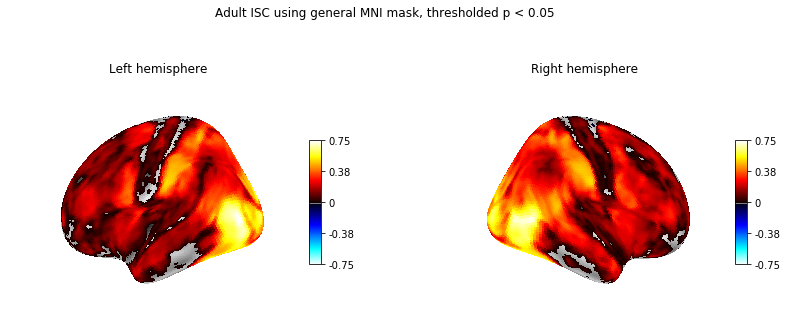

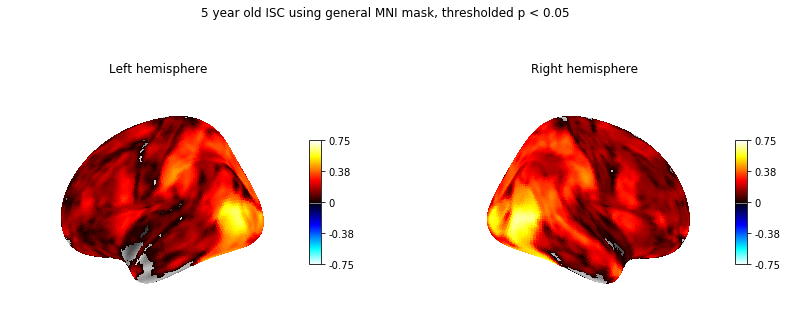

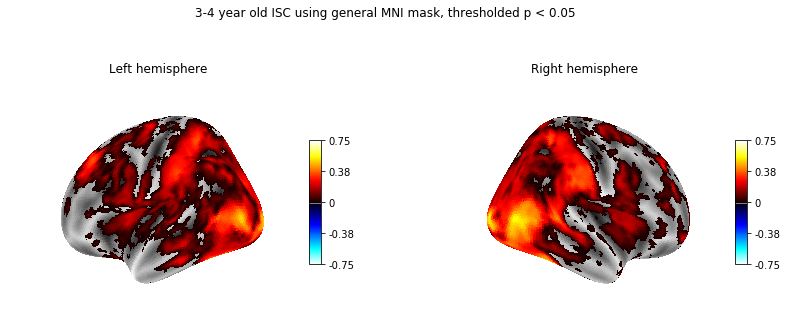

In [28]:
plot_lateral_only_with_vmax(vol=helpers.make_vol(isc_adults_thresholded, group_mask),
                 title='Adult ISC using general MNI mask, thresholded p < 0.05',
                 vis_threshold=0.01, vmax=0.75)

plot_lateral_only_with_vmax(vol=helpers.make_vol(isc_5yrs_thresholded, group_mask),
                 title='5 year old ISC using general MNI mask, thresholded p < 0.05',
                 vis_threshold=0.01, vmax=0.75)

plot_lateral_only_with_vmax(vol=helpers.make_vol(isc_34yrs_thresholded, group_mask),
                 title='3-4 year old ISC using general MNI mask, thresholded p < 0.05',
                 vis_threshold=0.01, vmax=0.75)

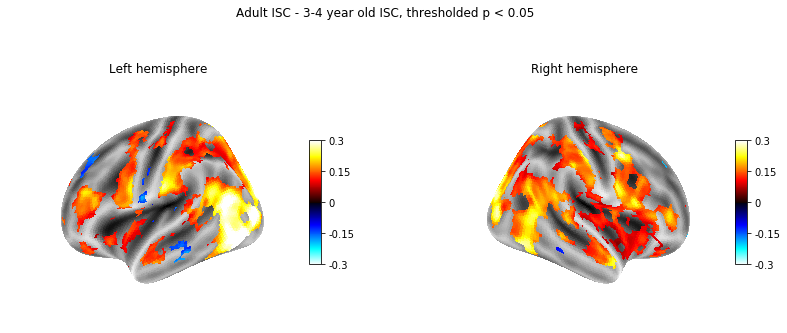

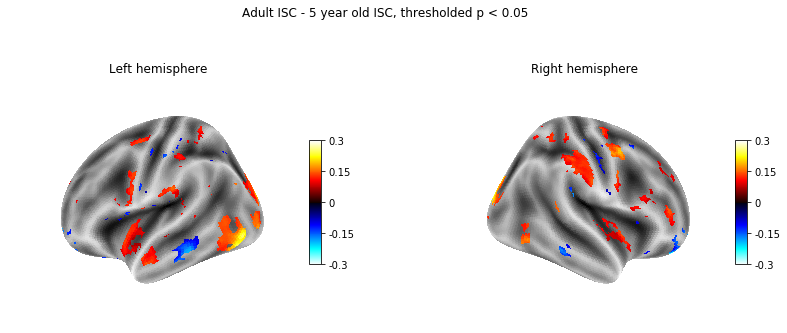

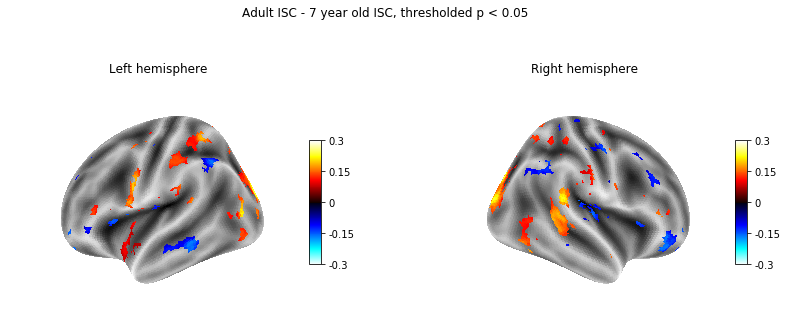

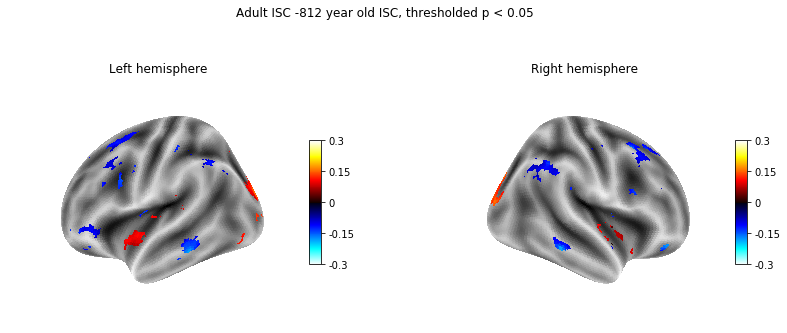

In [23]:
plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_34yrs_thresholded, mask),
                 title='Adult ISC - 3-4 year old ISC, thresholded p < 0.05',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_5yrs_thresholded, mask),
                 title='Adult ISC - 5 year old ISC, thresholded p < 0.05',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_7yrs_thresholded, mask),
                 title='Adult ISC - 7 year old ISC, thresholded p < 0.05',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_812yrs_thresholded, mask),
                 title='Adult ISC -812 year old ISC, thresholded p < 0.05',
                 vis_threshold=0, vmax=0.3)

In [ ]:
plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_34yrs_diff, mask),
                 title='Adult ISC - 3-4 year old ISC, unthresholded',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_5yrs_diff, mask),
                 title='Adult ISC - 5 year old ISC, unthresholded',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_7yrs_diff, mask),
                 title='Adult ISC - 7 year old ISC, unthresholded',
                 vis_threshold=0, vmax=0.3)

plot_lateral_only_with_vmax(vol=helpers.make_vol(adults_812yrs_diff, mask),
                 title='Adult ISC -812 year old ISC, unthresholded',
                 vis_threshold=0, vmax=0.3)